In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd

import lsst.sims.maf.db as db
import lsst.sims.maf.metrics as metrics
import lsst.sims.maf.stackers as stackers
import lsst.sims.maf.slicers as slicers
import lsst.sims.maf.plots as plots
import lsst.sims.maf.metricBundles as mb

#### This file can be replaced with any of the opsim files

In [ ]:
opsfilename = 'minion_1016_newsky.db'
opsdb       = db.OpsimDatabase(opsfilename)

simdata = opsdb.query_columns(opsdb.defaultTable, 
                              colnames=['fieldRA', 'fieldDec', 'filter', 'night', 'visitTime', 'airmass', 'filtSkyBrightness', 'expMJD'], 
                              sqlconstraint=None)

### Putting OpSim columns in arrays to make it easier to work with

In [ ]:
ra_array      = np.zeros(len(simdata))
dec_array     = np.zeros(len(simdata))
airmass_array = np.zeros(len(simdata))
time_array    = np.zeros(len(simdata))
night_array   = np.zeros(len(simdata))

# creating empty array for strings for filter names
val           = [''] * len(simdata)
filter_array  = np.array(val)

for i in range(len(simdata)):
    ra_array[i]      = simdata[i][0]
    dec_array[i]     = simdata[i][1]
    filter_array[i]  = simdata[i][2]
    night_array[i]   = simdata[i][3]
    time_array[i]    = simdata[i][7] # time should be expMJD
    airmass_array[i] = simdata[i][5]

In [5]:
import sncosmo
from   astropy.table    import Table
import numpy            as np
import matplotlib.pylab as plt
from   astropy.io       import ascii

#### Setting the filename of sampled supernova parameters. 
This file is obtained by running SNTable notebook that Rahul has. It has (x0,x1,c,t0,z) and host galaxy information. t0 is the peak magnitude time of each supernova.

In [6]:
filename = "/global/homes/a/anitab/DC2_run1p1_TransientDocs/Notebooks/Hosted_SN_table.csv"
from pandas import read_csv

vvv  = read_csv(filename)
data = vvv['galaxy_id c mB t0 x0 x1 z random_Hosting rand_host zbin "Unnamed: 0" diskMassStellar morphology/diskHalfLightRadiusArcsec morphology/diskMinorAxisArcsec morphology/positionAngle morphology/spheroidHalfLightRadiusArcsec morphology/spheroidMinorAxisArcsec size_bulge_true size_disk_true totalMassStellar uniqueId raJ2000_gal decJ2000_gal z zbin_gals snid']

# uncomment this to see what columns are available
###vvv.columns 

### Sampled SN properties in an array
$m_B = 10.635 - \log_{10}(x0)$

In [8]:
length  = len(data)

zvals   = np.zeros(length) 
x0vals  = np.zeros(length)
x1vals  = np.zeros(length)
cvals   = np.zeros(length)
mBvals  = np.zeros(length)
t0vals  = np.zeros(length)
smass   = np.zeros(length)
ravals  = np.zeros(length)
decvals = np.zeros(length)

for i in range(length):
    zvals[i]   = data[i].split()[6]  # redshifts
    x0vals[i]  = data[i].split()[4]  # x0 values
    x1vals[i]  = data[i].split()[5]  # x1 values
    cvals[i]   = data[i].split()[1]  # c values
    mBvals[i]  = data[i].split()[2]  # mB values
    t0vals[i]  = data[i].split()[3]  # Peak magnitude
    smass[i]   = data[i].split()[20] # Stellar mass of host galaxy
    ravals[i]  = data[i].split()[21] # Ra of SN
    decvals[i] = data[i].split()[22] # Dec of SN

### Choosing rows of OpSim based on sampled SNe

In [9]:
import os
import opsimsummary as oss
import healpy as hp
print(oss.__version__)

Some imports failed, which implies some dependencies are missing as described below
No module named 'mpl_toolkits.basemap'
Visulization functions based on maps will not work
1.16.1


In [10]:
from opsimsummary import SynOpSim

I need to make sure angleUnit has 'degrees' attribute

In [12]:
synopsim  = SynOpSim.fromOpSimDB(opsfilename, opsimversion='lsstv3',
                                angleUnit='degrees', usePointingTree=True)

 reading from database sqlite:///minion_1016_newsky.db
SELECT * FROM Summary WHERE propID in (56, 54)


### Generator
This is a Python generator function to make going through data faster. This goes through the observing file and uses Ra and Dec of sampled SNe to determine which SNe would be visible at which times.

In [13]:
gen = synopsim.pointingsEnclosing(ravals, decvals, circRadius=0., pointingRadius=1.75, usePointingTree=True)

### Time and filters from OpSim file
This is going through the generator and inserting times of observation and filer names in a list. After running this for loop, if we need to go through the generator again, we need to run the gen = ... line again because the generator has now gone all the way to the end. So, we need ro rerun this line:

gen = synopsim.pointingsEnclosing(ravals, decvals, circRadius=0., pointingRadius=1.75, usePointingTree=True)

In [14]:
timeopsim_list   = []
filteropsim_list = []

for i, df in enumerate(gen):
    
    timeopsim = df['expMJD']
    timeopsim_list.append(timeopsim.values)
    
    filteropsim = df['filter']
    filteropsim_list.append(filteropsim.values)
    
    #raopsim = df['fieldRA']
    #raopsim_list.append(raopsim.values)
    ###raopsim_list += raopsim.values.tolist() # this is to make the 2D array into 1D array. Not needed in general though

### Plotting SNe and their corresponding OpSim points
This shows supernovae as red dots and the OpSim visits as blue dots. There might be multiple visits at the same location so some points are overlapping and they are for different times.

In [ ]:
ifx      = np.array([21,22,23,24,25]) # subplot numbers (for turning x ticks on/off)
ify      = np.array([1,6,11,16,21])   # subplot numbers (for turning y ticks on/off)

plt.figure(1, figsize=(15,15))

for i in range(25):
    
    plt.subplot(5,5,i+1)
    plt.plot(np.rad2deg(decopsim_list[1000*i]), np.rad2deg(raopsim_list[1000*i]), ".", color="blue")
    plt.plot(decvals[1000*i], ravals[1000*i], ".", color="red")
    plt.ylim(50,60)
    plt.xlim(-34,-24)
    plt.tick_params(axis='both', labelleft='off', labelbottom='off')

    if i+1 in ifx:
        plt.xlabel("Ra [deg]",fontsize=15)
        plt.tick_params(axis='x', labelbottom='on')
    if i+1 in ify:
        plt.ylabel("Dec [deg]",fontsize=15)
        plt.tick_params(axis='y', labelleft='on')
    
plt.suptitle("SNe in red with opsim visits in blue")

### Checking time range of OpSim with $t_0$
Looping over all supernova and checking the observing times corresponding to supernova location from OpSim file and adding the ones that are within (t0 - 19 < OpSimtime < t0+49 ) range. This is the SALT model time range. If the OpSim time is not within this time range, the flux calculated would be 0 and we do not get any useful information. So, I want to reduce the number of data and only work with the useful data.

In [26]:
from lsst.sims.catUtils.supernovae import SNObject
from lsst.sims.photUtils.BandpassDict import BandpassDict

# Setting the LSST BandPass object to be used in BandFlux function
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()

mlist     = []
jlist_tot = []

for m in range(len(timeopsim_list)):
    jlist = []
    for j in range(len(timeopsim_list[m])):
        if (timeopsim_list[m][j] > t0vals[m] -19 and timeopsim_list[m][j] < t0vals[m] + 49):
            jlist.append(j)
    if jlist:
        mlist.append(m)
        jlist_tot.append(jlist)

### Calculating the flux
Goes through a loop for each supernova and sets the parameters for each and then calculates the flux for all the visits

In [119]:
fluxlist_tot = [] 
timelist_tot = []

# Going through each SN
for SN_id, val in enumerate(mlist[:50]):
    # setting parameters for each supernova
    params   = {'x0': x0vals[val], 'x1': x1vals[val], 'c': cvals[val], 't0':t0vals[val]}
    snobject = SNObject(ravals[val], decvals[val])
    snobject.set(**params)
    
    # to make filternames what the code accepts using list comprehension to make it faster
    filters_modified = [LSST_BandPass[key] for key in filteropsim_list[val]]

    fluxlist = []
    timelist = []
    
    # going through all the visits for each single supernova
    for j in jlist_tot[SN_id]:
        fluxval = snobject.catsimBandFlux(bandpassobject = filters_modified[j], time = timeopsim_list[val][j])
        fluxlist.append(fluxval)
        timelist.append(timeopsim_list[val][j]) # appending the times of observation to a list
        
    
    fluxlist_tot.append(fluxlist) # shape should be (number of SN, entries for each SN)
    timelist_tot.append(timelist) # shape should be (number of SN, entries for each SN)

### Plotting flux vs. time
This is the fluxes obtained using catsimBandFlux() function for a selection of SNe vs expMJD time. The points are fluxes in all bands so that is why they have funny and oscillating shapes.

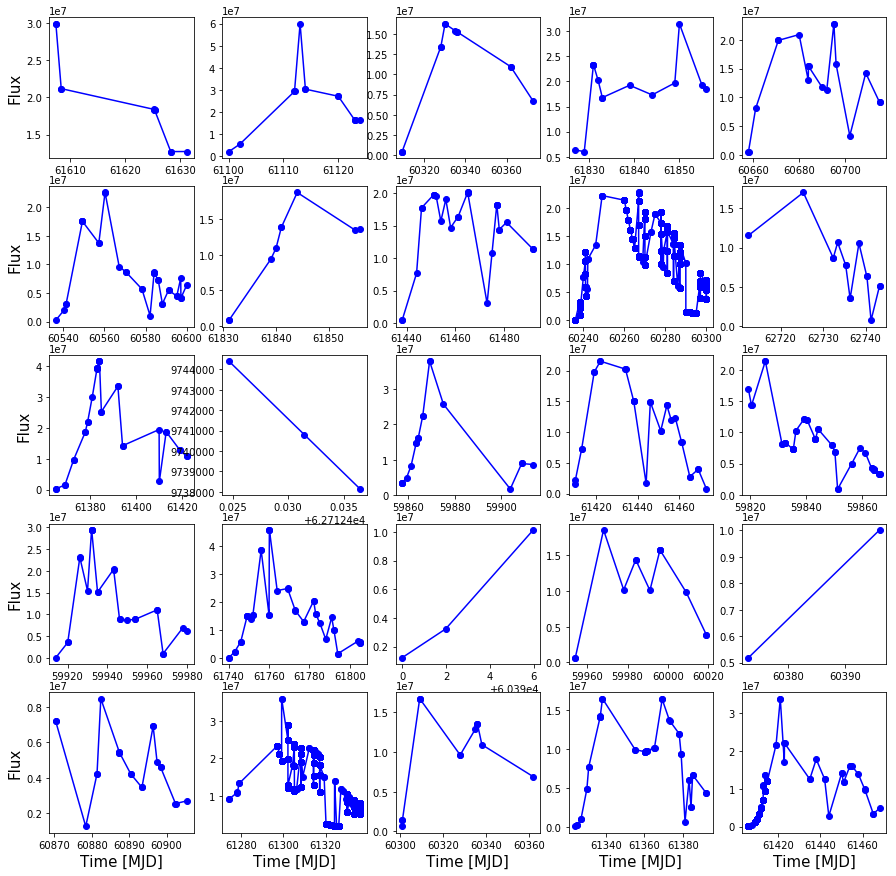

In [145]:
ifx      = np.array([21,22,23,24,25]) # subplot numbers (for turning x ticks on/off)
ify      = np.array([1,6,11,16, 21])

plt.figure(1, figsize=(15,15))

for i in range(25):
    plt.subplot(5,5,i+1)
    
    indx = np.arange(0,len(timelist_tot[i]))
    Z = [x for _,x in sorted(zip(timelist_tot[i],indx))]
    
    plt.plot(np.sort(timelist_tot[i]), np.array(fluxlist_tot[i])[Z], "o", color='blue')
    plt.plot(np.sort(timelist_tot[i]), np.array(fluxlist_tot[i])[Z], color='blue')
    
    #plt.tick_params(axis='both', labelleft='off', labelbottom='off')

    if i+1 in ifx:
        plt.xlabel("Time [MJD]",fontsize=15)
    #    plt.tick_params(axis='x', labelbottom='on')
    if i+1 in ify:
        plt.ylabel("Flux",fontsize=15)
    #    plt.tick_params(axis='y', labelleft='on')
    

### LSST code example that works!

In [ ]:
bandpassnames = ['u', 'g', 'r', 'i', 'z', 'y']
from lsst.sims.photUtils.BandpassDict import BandpassDict
LSST_BandPass = BandpassDict.loadTotalBandpassesFromFiles()
SN = SNObject(ra=30., dec=-60.)
SN.set(z=0.96, t0=571181, x1=2.66, c=0.353, x0=1.796112e-06)
SN.catsimBandFlux(bandpassobject=LSST_BandPass['r'], time=571190.)

### $m_B$ obtained from $x_0$

In [ ]:
def mB(x0):
    return 10.635 - (2.5 * np.log10(x0))